Librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

Obtención de datos

In [33]:
cycle_train = pd.read_excel('bike_train.xlsx', sheet_name='Sheet1')
cycle_test = pd.read_excel('bike_test.xlsx', sheet_name='Sheet1')

Exploración

In [3]:
df_cent = cycle_train.describe()
df_cent

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000
mean,6000.000000,2.210684,0.279523,5.530294,11.556630,0.027752,3.009334,0.684057,1.435036,0.465704,0.448888,0.625770,0.196433,30.049837,128.545129,158.594966
std,3463.957275,1.088798,0.448784,3.433005,6.911891,0.164269,2.005264,0.464910,0.650894,0.188576,0.169633,0.200637,0.125394,43.596915,124.692750,151.392952
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3000.500000,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.303000,0.470000,0.104500,3.000000,29.000000,34.000000
50%,6000.000000,2.000000,0.000000,5.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.460000,0.454500,0.620000,0.194000,13.000000,98.000000,118.000000
75%,8999.500000,3.000000,1.000000,8.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.620000,0.590900,0.790000,0.283600,39.000000,185.000000,232.000000
max,11999.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.000000,1.000000,0.850700,367.000000,770.000000,957.000000


In [4]:
#outliers registered
registered_iqr = df_cent.loc['75%', 'registered'] - df_cent.loc['25%', 'registered']
registered_min = df_cent.loc['25%', 'registered'] -1.5*registered_iqr
registered_max = df_cent.loc['75%', 'registered'] +1.5*registered_iqr
print('Rango outliers usuarios registrados:', '(-inf', ',', registered_min, ')', ', ', '(', registered_max, ',', 'inf)')

#outliers casual
casual_iqr = df_cent.loc['75%', 'casual'] - df_cent.loc['25%', 'casual']
casual_min = df_cent.loc['25%', 'casual'] -1.5*casual_iqr
casual_max = df_cent.loc['75%', 'casual'] +1.5*casual_iqr
print('Rango outliers usuarios casuales:', '(-inf', ',', casual_min, ')', ', ', '(', casual_max, ',', 'inf)')

Rango outliers usuarios registrados: (-inf , -205.0 ) ,  ( 419.0 , inf)
Rango outliers usuarios casuales: (-inf , -51.0 ) ,  ( 93.0 , inf)


In [5]:
indx_out_reg = []
indx_out_cas = []
for i in cycle_train.index.values:
    if (cycle_train.loc[i, 'registered'] < registered_min) or (cycle_train.loc[i, 'registered'] > registered_max):
        indx_out_reg.append(i)
    if (cycle_train.loc[i, 'casual'] < casual_min) or (cycle_train.loc[i, 'casual'] > casual_max):
        indx_out_cas.append(i)        
print(len(indx_out_reg), len(indx_out_cas))

491 901


In [6]:
cycle_train_outliers = cycle_train
cycle_train_outliers.loc[indx_out_reg, 'registered'] = registered_max
cycle_train_outliers.loc[indx_out_cas, 'casual'] = casual_max
cycle_train_outliers['cnt'] = cycle_train_outliers.apply(lambda r: r['registered']+r['casual'], axis=1)

In [7]:
cycle_train_outliers.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000
mean,6000.000000,2.210684,0.279523,5.530294,11.556630,0.027752,3.009334,0.684057,1.435036,0.465704,0.448888,0.625770,0.196433,25.484040,124.749896,150.233936
std,3463.957275,1.088798,0.448784,3.433005,6.911891,0.164269,2.005264,0.464910,0.650894,0.188576,0.169633,0.200637,0.125394,28.690662,112.919574,132.370014
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3000.500000,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.303000,0.470000,0.104500,3.000000,29.000000,34.000000
50%,6000.000000,2.000000,0.000000,5.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.460000,0.454500,0.620000,0.194000,13.000000,98.000000,118.000000
75%,8999.500000,3.000000,1.000000,8.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.620000,0.590900,0.790000,0.283600,39.000000,185.000000,231.000000
max,11999.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.000000,1.000000,0.850700,93.000000,419.000000,512.000000


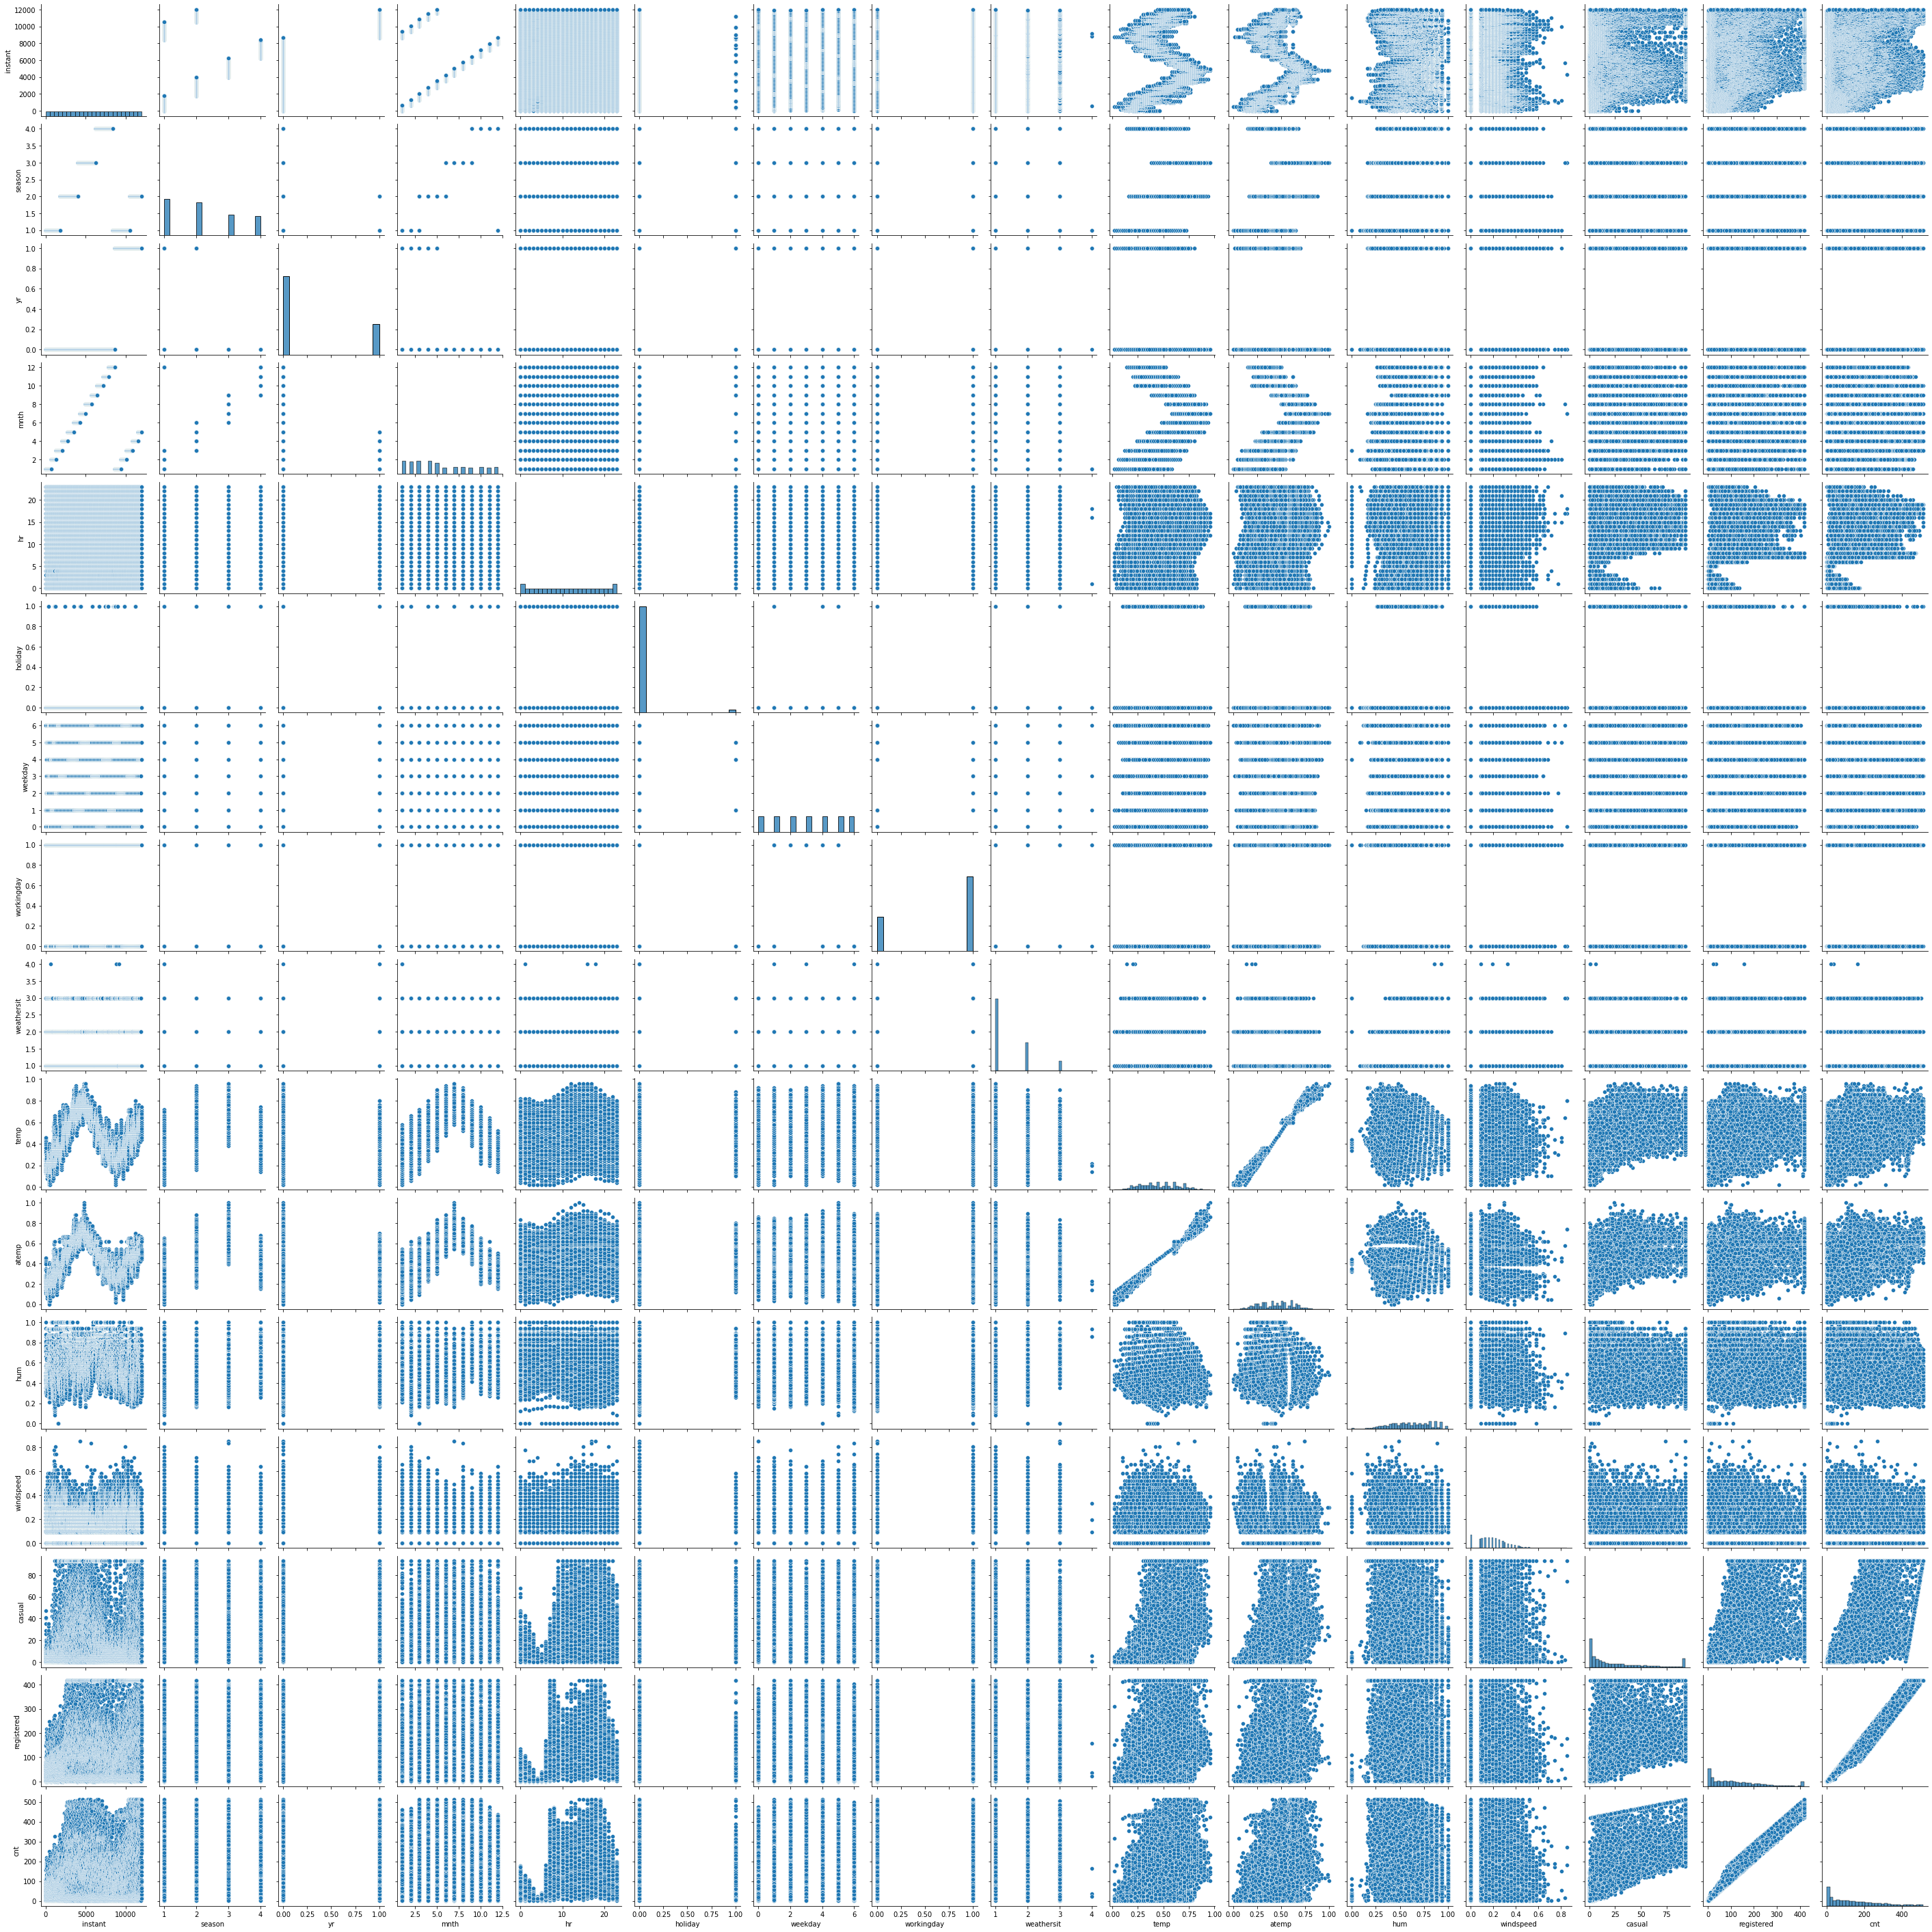

In [8]:
sns.pairplot(data=cycle_train)

In [9]:
corr = cycle_train.corr()
print(corr)

             instant    season        yr      mnth        hr   holiday  \
instant     1.000000  0.118039  0.777284  0.167195 -0.007446  0.008323   
season      0.118039  1.000000 -0.446665  0.865268 -0.007610 -0.008928   
yr          0.777284 -0.446665  1.000000 -0.488103 -0.003948  0.001039   
mnth        0.167195  0.865268 -0.488103  1.000000 -0.007060  0.009372   
hr         -0.007446 -0.007610 -0.003948 -0.007060  1.000000  0.000414   
holiday     0.008323 -0.008928  0.001039  0.009372  0.000414  1.000000   
weekday     0.007103 -0.003688 -0.002714  0.014500 -0.004037 -0.102503   
workingday  0.005295  0.012630  0.001068  0.006441  0.003454 -0.248601   
weathersit -0.015359 -0.009029 -0.006309 -0.012239 -0.024003 -0.014707   
temp        0.029297  0.410790 -0.198929  0.353330  0.139251 -0.028519   
atemp       0.042490  0.413196 -0.190360  0.358541  0.134633 -0.038005   
hum        -0.013275  0.198937 -0.141319  0.201669 -0.257202 -0.036672   
windspeed  -0.029001 -0.142924  0.0673

Modelo de predicción ¿KNeighborsRegressor, DecisionTreeRegressor, RandomForestRegressor, ExtraTreesRegressor?

In [10]:
#Preparación de datos para predicción
cycle_train['date_number'] = cycle_train['dteday'].map(dt.datetime.toordinal)
#No se tomarán en cuenta para features: instant: por ser un identificador; yr y mnth: por estar incluidos en la fecha
#features
x = cycle_train[['date_number', 'season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
#target
y = cycle_train[['casual', 'registered', 'cnt']]
y1 = cycle_train_outliers[['casual', 'registered', 'cnt']]
#20% de los datos se tomarán como datos de prueba
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size = 0.20, random_state = 42)

Total

Curvas de validación

Text(0.5, 0, 'Cantidad de Vecinos')

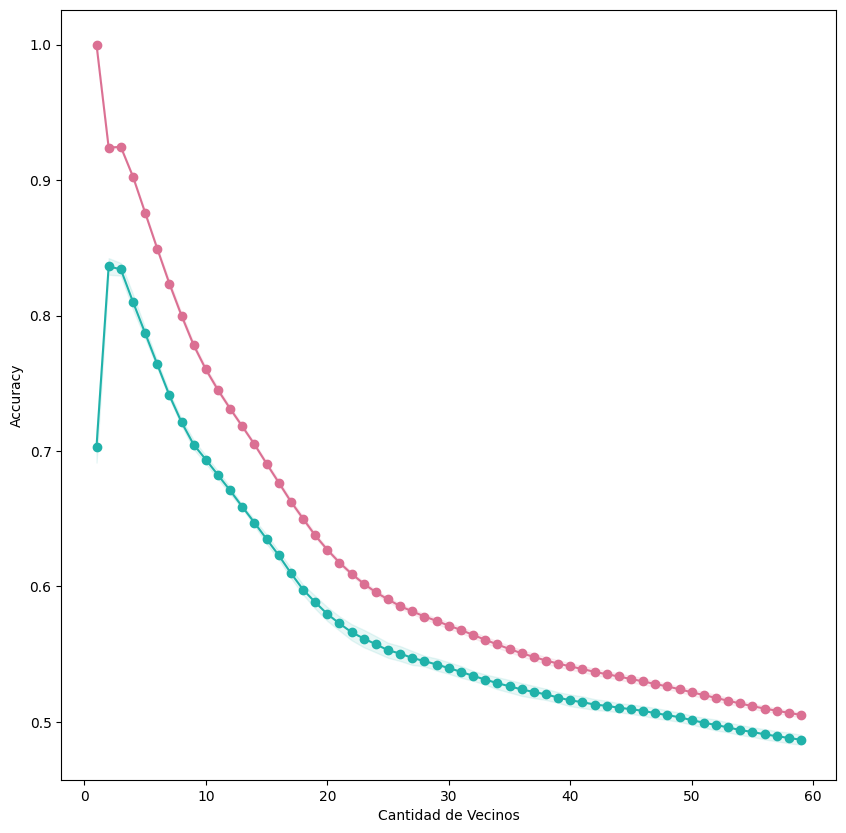

In [11]:
# KNeighborsRegressor
#listas de entrenamiento
knntrain_scoremean = []
knntrain_scorestd = []
#listas de prueba
knntst_scoremean = []
knntst_scorestd = []
#valores para vecinos
vecinos = np.arange(1,60,1)
for k in vecinos:
    model_knn =  KNeighborsRegressor(n_neighbors=k)
    #usamos cross_validate para obtener los scores de validación
    knn_scores = cross_validate(model_knn, xtrain, ytrain['cnt'], cv=5, return_train_score=True, n_jobs = -1)
    #agregamos el score correspondiente a cada lista
    knntrain_scoremean.append(knn_scores['train_score'].mean())
    knntrain_scorestd.append(knn_scores['train_score'].std())
    knntst_scoremean.append(knn_scores['test_score'].mean())
    knntst_scorestd.append(knn_scores['test_score'].std())
#Convertimos listas en arrays
knntrain_scoremean = np.array(knntrain_scoremean)
knntrain_scorestd = np.array(knntrain_scorestd)
knntst_scoremean = np.array(knntst_scoremean)
knntst_scorestd = np.array(knntst_scorestd)
#Gráficamos
plt.figure(figsize=(10,10))
plt.fill_between(vecinos, knntrain_scoremean - knntrain_scorestd,
knntrain_scoremean + knntrain_scorestd,
alpha=0.1, color="PaleVioletRed")
plt.fill_between(vecinos, knntst_scoremean - knntst_scorestd,
knntst_scoremean + knntst_scorestd,
alpha=0.1, color="LightSeaGreen")
plt.plot(vecinos, knntrain_scoremean, 'o-', color="PaleVioletRed", label="Training score")
plt.plot(vecinos, knntst_scoremean, 'o-', color="LightSeaGreen", label="Test score")
plt.ylabel('Accuracy')
plt.xlabel('Cantidad de Vecinos')

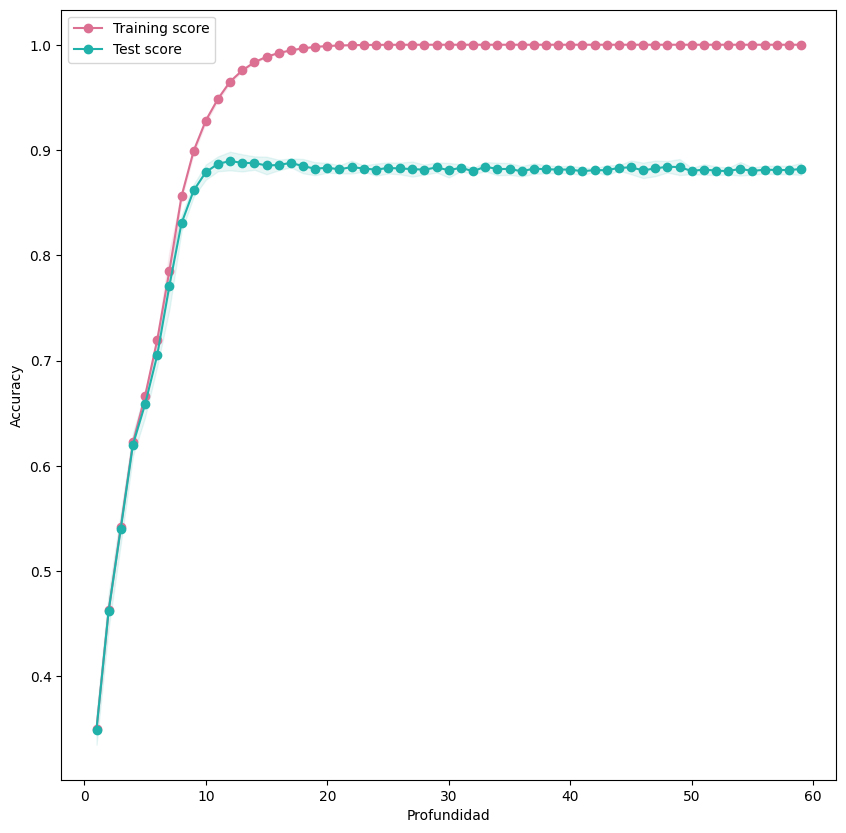

In [12]:
# DecisionTreeRegressor
# listas de entrenamiento
treetrain_scoremean = []
treetrain_scorestd = []
#listas de prueba
treetst_scoremean = []
treetst_scorestd = []
# valores de profundidad
depth_n = np.arange(1,60,1)
for d in depth_n:
    model_tree = DecisionTreeRegressor(max_depth=d)
    #usamos cross_validate para obtener los scores de validación
    tree_scores = cross_validate(model_tree, xtrain, ytrain['cnt'], cv=5, return_train_score=True, n_jobs = -1)
    #agregamos el score correspondiente a cada lista
    treetrain_scoremean.append(tree_scores['train_score'].mean())
    treetrain_scorestd.append(tree_scores['train_score'].std())
    treetst_scoremean.append(tree_scores['test_score'].mean())
    treetst_scorestd.append(tree_scores['test_score'].std())
#Convertimos listas en arrays
treetrain_scoremean = np.array(treetrain_scoremean)
treetrain_scorestd = np.array(treetrain_scorestd)
treetst_scoremean = np.array(treetst_scoremean)
treetst_scorestd = np.array(treetst_scorestd)
#Gráficamos
plt.figure(figsize=(10,10))
plt.fill_between(depth_n, treetrain_scoremean - treetrain_scorestd,
treetrain_scoremean + treetrain_scorestd,
alpha=0.1, color="PaleVioletRed")
plt.fill_between(depth_n, treetst_scoremean - treetst_scorestd,
treetst_scoremean + treetst_scorestd,
alpha=0.1, color="LightSeaGreen")
plt.plot(depth_n, treetrain_scoremean, 'o-', color="PaleVioletRed", label="Training score")
plt.plot(depth_n, treetst_scoremean, 'o-', color="LightSeaGreen", label="Test score")
plt.ylabel('Accuracy')
plt.xlabel('Profundidad')
plt.legend()
plt.show()

GridSearchCV

In [13]:
#RandomForestRegressor
rfr_params = {'n_estimators': [300], 'n_jobs': [-1], 'max_features': [1.0, 'sqrt', 'log2', 'None']}
model_rfr = GridSearchCV(RandomForestRegressor(), rfr_params, cv=5, scoring = 'neg_mean_squared_error')
model_rfr.fit(xtrain, ytrain['cnt'].values)

#ExtraTreesRegressor
etr_params = {'n_estimators': [300], 'n_jobs': [-1], 'max_features': [1.0, 'sqrt', 'log2', 'None']}
model_etr = GridSearchCV(ExtraTreesRegressor(), etr_params, cv=5, scoring = 'neg_mean_squared_error')
model_etr.fit(xtrain, ytrain['cnt'].values)

/home/aury/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 595, in __

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_features': [1.0, 'sqrt', 'log2', 'None'],
                         'n_estimators': [300], 'n_jobs': [-1]},
             scoring='neg_mean_squared_error')

In [14]:
print(model_rfr.best_params_)
print(model_etr.best_params_)

{'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}
{'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}


Error en modelos

In [ ]:
#SVR
# model_svr = SVR(kernel="rbf", C=1000, gamma=0.1, epsilon=0.1)
# model_svr.fit(xtrain, ytrain['cnt'].values)

In [15]:
# KNeighborsRegressor
model_knn =  KNeighborsRegressor(n_neighbors=3)
model_knn.fit(xtrain, ytrain['cnt'].values)
knn_ytrain_pred = model_knn.predict(xtrain)
knn_ytest_pred = model_knn.predict(xtest)
print('KNeighborsRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['cnt'].values, knn_ytrain_pred))
print('Error en datos de test:', mean_squared_error(ytest['cnt'].values, knn_ytest_pred))
# DecisionTreeRegressor
model_tree = DecisionTreeRegressor(max_depth=12)
model_tree.fit(xtrain, ytrain['cnt'].values)
tree_ytrain_pred = model_tree.predict(xtrain)
tree_ytest_pred = model_tree.predict(xtest)
print('DecisionTreeRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['cnt'].values, tree_ytrain_pred))
print('Error en datos de test:', mean_squared_error(ytest['cnt'].values, tree_ytest_pred))
# SVR
# svr_ytrain_pred = model_svr.predict(xtrain)
# svr_ytest_pred = model_svr.predict(xtest)
# print('SVR')
# print('Error en datos de train:', mean_squared_error(ytrain['cnt'].values, svr_ytrain_pred))
# print('Error en datos de test:', mean_squared_error(ytest['cnt'].values, svr_ytest_pred))
# RandomForestRegressor
rfr_ytrain_pred = model_rfr.predict(xtrain)
rfr_ytest_pred = model_rfr.predict(xtest)
print('RandomForestRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['cnt'].values, rfr_ytrain_pred))
print('Error en datos de test:', mean_squared_error(ytest['cnt'].values, rfr_ytest_pred))
# ExtraTreesRegressor
etr_ytrain_pred = model_etr.predict(xtrain)
etr_ytest_pred = model_etr.predict(xtest)
print('ExtraTreesRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['cnt'].values, etr_ytrain_pred))
print('Error en datos de test:', mean_squared_error(ytest['cnt'].values, etr_ytest_pred))

KNeighborsRegressor
Error en datos de train: 1049.14915905592
Error en datos de test: 2278.3752777777777
DecisionTreeRegressor
Error en datos de train: 654.2335491972668
Error en datos de test: 1539.4286649967744
RandomForestRegressor
Error en datos de train: 134.12167041126972
Error en datos de test: 934.2696984398148
ExtraTreesRegressor
Error en datos de train: 9.082196062089964e-05
Error en datos de test: 969.8949396527778


Modelo por tipo de usuario

Registrado

Curvas de validación

Text(0.5, 0, 'Cantidad de Vecinos')

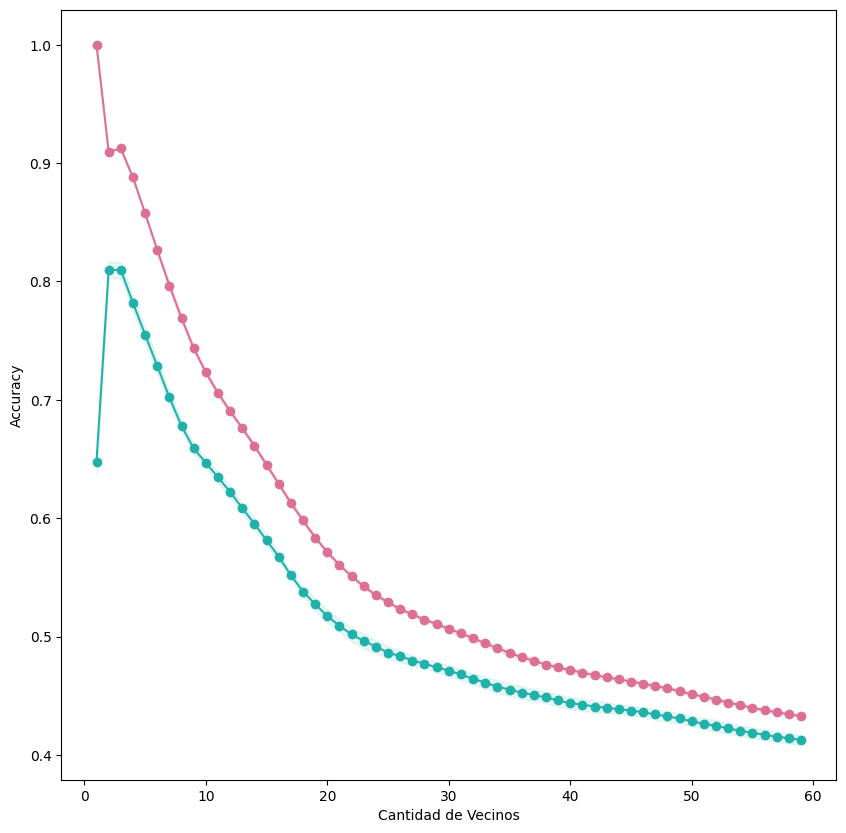

In [16]:
# KNeighborsRegressor
#listas de entrenamiento
knntrain_scoremean = []
knntrain_scorestd = []
#listas de prueba
knntst_scoremean = []
knntst_scorestd = []
#valores para vecinos
vecinos = np.arange(1,60,1)
for k in vecinos:
    model_knn =  KNeighborsRegressor(n_neighbors=k)
    #usamos cross_validate para obtener los scores de validación
    knn_scores = cross_validate(model_knn, xtrain, ytrain['registered'], cv=5, return_train_score=True, n_jobs = -1)
    #agregamos el score correspondiente a cada lista
    knntrain_scoremean.append(knn_scores['train_score'].mean())
    knntrain_scorestd.append(knn_scores['train_score'].std())
    knntst_scoremean.append(knn_scores['test_score'].mean())
    knntst_scorestd.append(knn_scores['test_score'].std())
#Convertimos listas en arrays
knntrain_scoremean = np.array(knntrain_scoremean)
knntrain_scorestd = np.array(knntrain_scorestd)
knntst_scoremean = np.array(knntst_scoremean)
knntst_scorestd = np.array(knntst_scorestd)
#Gráficamos
plt.figure(figsize=(10,10))
plt.fill_between(vecinos, knntrain_scoremean - knntrain_scorestd,
knntrain_scoremean + knntrain_scorestd,
alpha=0.1, color="PaleVioletRed")
plt.fill_between(vecinos, knntst_scoremean - knntst_scorestd,
knntst_scoremean + knntst_scorestd,
alpha=0.1, color="LightSeaGreen")
plt.plot(vecinos, knntrain_scoremean, 'o-', color="PaleVioletRed", label="Training score")
plt.plot(vecinos, knntst_scoremean, 'o-', color="LightSeaGreen", label="Test score")
plt.ylabel('Accuracy')
plt.xlabel('Cantidad de Vecinos')

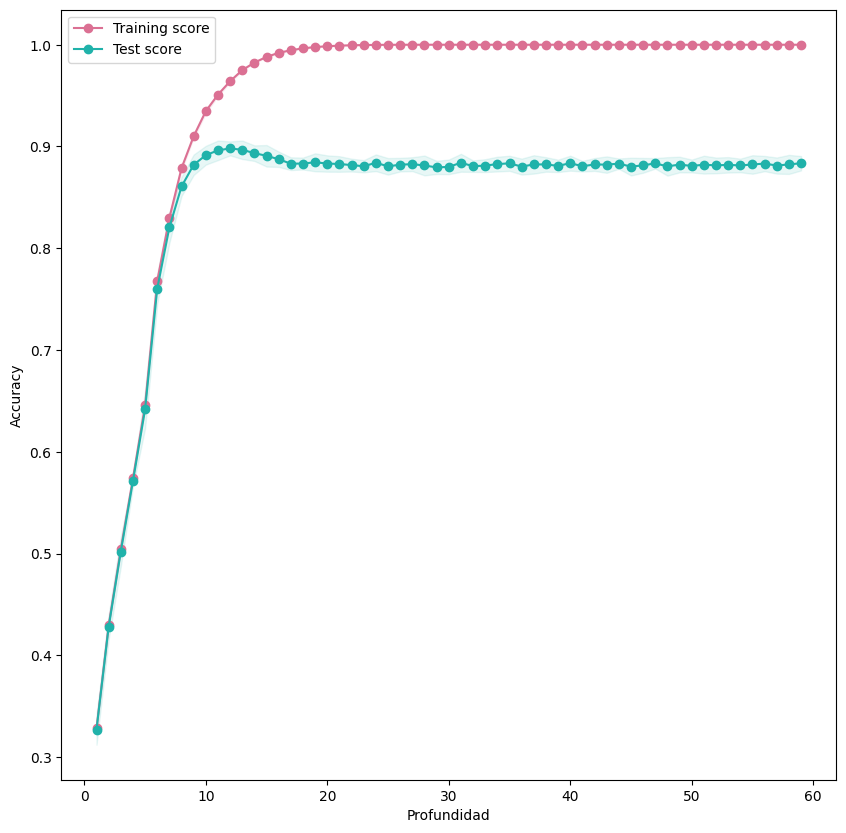

In [17]:
# DecisionTreeRegressor
# listas de entrenamiento
treetrain_scoremean = []
treetrain_scorestd = []
#listas de prueba
treetst_scoremean = []
treetst_scorestd = []
# valores de profundidad
depth_n = np.arange(1,60,1)
for d in depth_n:
    model_tree = DecisionTreeRegressor(max_depth=d)
    #usamos cross_validate para obtener los scores de validación
    tree_scores = cross_validate(model_tree, xtrain, ytrain['registered'], cv=5, return_train_score=True, n_jobs = -1)
    #agregamos el score correspondiente a cada lista
    treetrain_scoremean.append(tree_scores['train_score'].mean())
    treetrain_scorestd.append(tree_scores['train_score'].std())
    treetst_scoremean.append(tree_scores['test_score'].mean())
    treetst_scorestd.append(tree_scores['test_score'].std())
#Convertimos listas en arrays
treetrain_scoremean = np.array(treetrain_scoremean)
treetrain_scorestd = np.array(treetrain_scorestd)
treetst_scoremean = np.array(treetst_scoremean)
treetst_scorestd = np.array(treetst_scorestd)
#Gráficamos
plt.figure(figsize=(10,10))
plt.fill_between(depth_n, treetrain_scoremean - treetrain_scorestd,
treetrain_scoremean + treetrain_scorestd,
alpha=0.1, color="PaleVioletRed")
plt.fill_between(depth_n, treetst_scoremean - treetst_scorestd,
treetst_scoremean + treetst_scorestd,
alpha=0.1, color="LightSeaGreen")
plt.plot(depth_n, treetrain_scoremean, 'o-', color="PaleVioletRed", label="Training score")
plt.plot(depth_n, treetst_scoremean, 'o-', color="LightSeaGreen", label="Test score")
plt.ylabel('Accuracy')
plt.xlabel('Profundidad')
plt.legend()
plt.show()

GridSearchCV

In [18]:
#RandomForestRegressor
rfr_params = {'n_estimators': [300], 'n_jobs': [-1], 'max_features': [1.0, 'sqrt', 'log2', 'None']}
model_rfr = GridSearchCV(RandomForestRegressor(), rfr_params, cv=5, scoring = 'neg_mean_squared_error')
model_rfr.fit(xtrain, ytrain['registered'].values)

#ExtraTreesRegressor
etr_params = {'n_estimators': [300], 'n_jobs': [-1], 'max_features': [1.0, 'sqrt', 'log2', 'None']}
model_etr = GridSearchCV(ExtraTreesRegressor(), etr_params, cv=5, scoring = 'neg_mean_squared_error')
model_etr.fit(xtrain, ytrain['registered'].values)

/home/aury/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 595, in __

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_features': [1.0, 'sqrt', 'log2', 'None'],
                         'n_estimators': [300], 'n_jobs': [-1]},
             scoring='neg_mean_squared_error')

In [19]:
print(model_rfr.best_params_)
print(model_etr.best_params_)

{'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}
{'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}


Error en modelos

In [ ]:
#SVR
# model_svr = SVR(kernel="rbf", C=1000, gamma=0.1, epsilon=0.1)
# model_svr.fit(xtrain, ytrain['cnt'].values)

In [21]:
# KNeighborsRegressor
model_knn =  KNeighborsRegressor(n_neighbors=3)
model_knn.fit(xtrain, ytrain['registered'].values)
knn_ytrain_predr = model_knn.predict(xtrain)
knn_ytest_predr = model_knn.predict(xtest)
print('KNeighborsRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['registered'].values, knn_ytrain_predr))
print('Error en datos de test:', mean_squared_error(ytest['registered'].values, knn_ytest_predr))
# DecisionTreeRegressor
model_tree = DecisionTreeRegressor(max_depth=12)
model_tree.fit(xtrain, ytrain['registered'].values)
tree_ytrain_predr = model_tree.predict(xtrain)
tree_ytest_predr = model_tree.predict(xtest)
print('DecisionTreeRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['registered'].values, tree_ytrain_predr))
print('Error en datos de test:', mean_squared_error(ytest['registered'].values, tree_ytest_predr))
# SVR
# svr_ytrain_predr = model_svr.predict(xtrain)
# svr_ytest_predr = model_svr.predict(xtest)
# print('SVR')
# print('Error en datos de train:', mean_squared_error(ytrain['cnt'].values, svr_ytrain_pred))
# print('Error en datos de test:', mean_squared_error(ytest['cnt'].values, svr_ytest_pred))
# RandomForestRegressor
rfr_ytrain_predr = model_rfr.predict(xtrain)
rfr_ytest_predr = model_rfr.predict(xtest)
print('RandomForestRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['registered'].values, rfr_ytrain_predr))
print('Error en datos de test:', mean_squared_error(ytest['registered'].values, rfr_ytest_predr))
# ExtraTreesRegressor
etr_ytrain_predr = model_etr.predict(xtrain)
etr_ytest_predr = model_etr.predict(xtest)
print('ExtraTreesRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['registered'].values, etr_ytrain_predr))
print('Error en datos de test:', mean_squared_error(ytest['registered'].values, etr_ytest_predr))

KNeighborsRegressor
Error en datos de train: 899.5995763447582
Error en datos de test: 1887.9760185185185
DecisionTreeRegressor
Error en datos de train: 494.57042276179766
Error en datos de test: 1123.934927714549
RandomForestRegressor
Error en datos de train: 105.3903069405378
Error en datos de test: 707.6466898425927
ExtraTreesRegressor
Error en datos de train: 0.0002137722679445769
Error en datos de test: 688.4996958148148


Usuarios casuales

Curvas de validación

Text(0.5, 0, 'Cantidad de Vecinos')

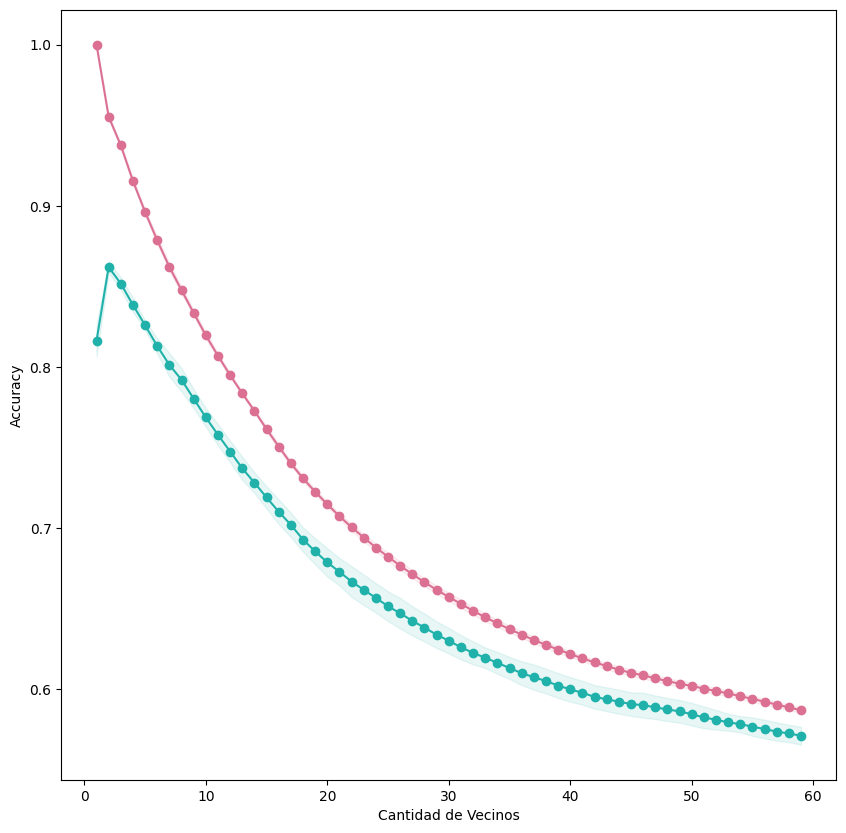

In [22]:
# KNeighborsRegressor
#listas de entrenamiento
knntrain_scoremean = []
knntrain_scorestd = []
#listas de prueba
knntst_scoremean = []
knntst_scorestd = []
#valores para vecinos
vecinos = np.arange(1,60,1)
for k in vecinos:
    model_knn =  KNeighborsRegressor(n_neighbors=k)
    #usamos cross_validate para obtener los scores de validación
    knn_scores = cross_validate(model_knn, xtrain, ytrain['casual'], cv=5, return_train_score=True, n_jobs = -1)
    #agregamos el score correspondiente a cada lista
    knntrain_scoremean.append(knn_scores['train_score'].mean())
    knntrain_scorestd.append(knn_scores['train_score'].std())
    knntst_scoremean.append(knn_scores['test_score'].mean())
    knntst_scorestd.append(knn_scores['test_score'].std())
#Convertimos listas en arrays
knntrain_scoremean = np.array(knntrain_scoremean)
knntrain_scorestd = np.array(knntrain_scorestd)
knntst_scoremean = np.array(knntst_scoremean)
knntst_scorestd = np.array(knntst_scorestd)
#Gráficamos
plt.figure(figsize=(10,10))
plt.fill_between(vecinos, knntrain_scoremean - knntrain_scorestd,
knntrain_scoremean + knntrain_scorestd,
alpha=0.1, color="PaleVioletRed")
plt.fill_between(vecinos, knntst_scoremean - knntst_scorestd,
knntst_scoremean + knntst_scorestd,
alpha=0.1, color="LightSeaGreen")
plt.plot(vecinos, knntrain_scoremean, 'o-', color="PaleVioletRed", label="Training score")
plt.plot(vecinos, knntst_scoremean, 'o-', color="LightSeaGreen", label="Test score")
plt.ylabel('Accuracy')
plt.xlabel('Cantidad de Vecinos')

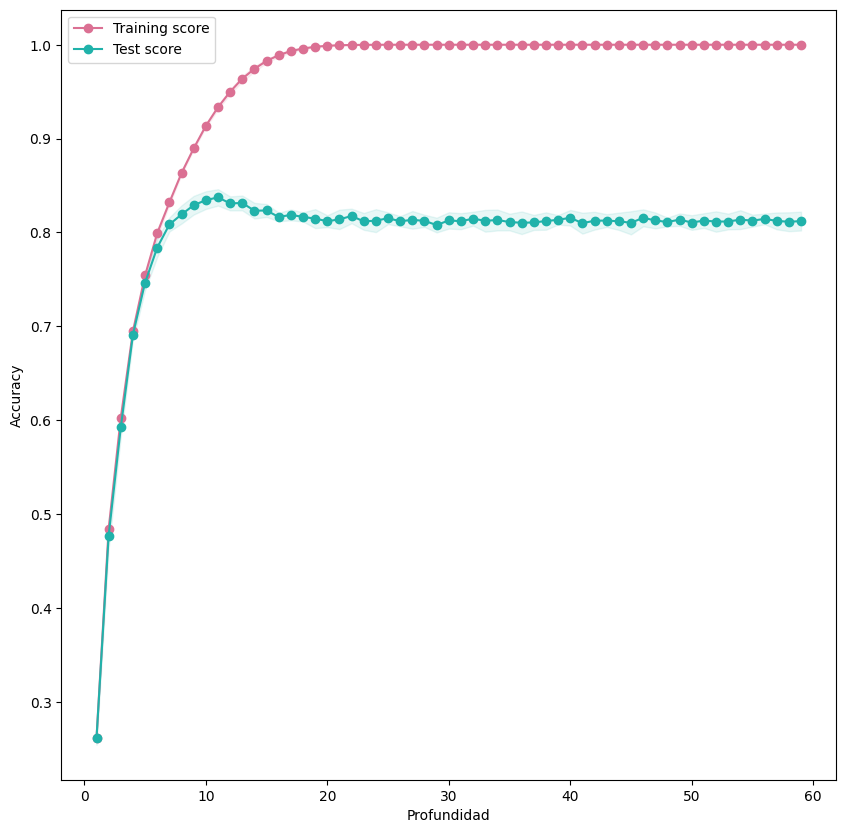

In [23]:
# DecisionTreeRegressor
# listas de entrenamiento
treetrain_scoremean = []
treetrain_scorestd = []
#listas de prueba
treetst_scoremean = []
treetst_scorestd = []
# valores de profundidad
depth_n = np.arange(1,60,1)
for d in depth_n:
    model_tree = DecisionTreeRegressor(max_depth=d)
    #usamos cross_validate para obtener los scores de validación
    tree_scores = cross_validate(model_tree, xtrain, ytrain['casual'], cv=5, return_train_score=True, n_jobs = -1)
    #agregamos el score correspondiente a cada lista
    treetrain_scoremean.append(tree_scores['train_score'].mean())
    treetrain_scorestd.append(tree_scores['train_score'].std())
    treetst_scoremean.append(tree_scores['test_score'].mean())
    treetst_scorestd.append(tree_scores['test_score'].std())
#Convertimos listas en arrays
treetrain_scoremean = np.array(treetrain_scoremean)
treetrain_scorestd = np.array(treetrain_scorestd)
treetst_scoremean = np.array(treetst_scoremean)
treetst_scorestd = np.array(treetst_scorestd)
#Gráficamos
plt.figure(figsize=(10,10))
plt.fill_between(depth_n, treetrain_scoremean - treetrain_scorestd,
treetrain_scoremean + treetrain_scorestd,
alpha=0.1, color="PaleVioletRed")
plt.fill_between(depth_n, treetst_scoremean - treetst_scorestd,
treetst_scoremean + treetst_scorestd,
alpha=0.1, color="LightSeaGreen")
plt.plot(depth_n, treetrain_scoremean, 'o-', color="PaleVioletRed", label="Training score")
plt.plot(depth_n, treetst_scoremean, 'o-', color="LightSeaGreen", label="Test score")
plt.ylabel('Accuracy')
plt.xlabel('Profundidad')
plt.legend()
plt.show()

GridSearchCV

In [24]:
#RandomForestRegressor
rfr_params = {'n_estimators': [300], 'n_jobs': [-1], 'max_features': [1.0, 'sqrt', 'log2', 'None']}
model_rfr = GridSearchCV(RandomForestRegressor(), rfr_params, cv=5, scoring = 'neg_mean_squared_error')
model_rfr.fit(xtrain, ytrain['casual'].values)

#ExtraTreesRegressor
etr_params = {'n_estimators': [300], 'n_jobs': [-1], 'max_features': [1.0, 'sqrt', 'log2', 'None']}
model_etr = GridSearchCV(ExtraTreesRegressor(), etr_params, cv=5, scoring = 'neg_mean_squared_error')
model_etr.fit(xtrain, ytrain['casual'].values)

/home/aury/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 436, in _process_worker
    r = call_item()
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py", line 288, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/home/aury/.local/lib/python3.10/site-packages/joblib/_parallel_backends.py", line 595, in __

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_features': [1.0, 'sqrt', 'log2', 'None'],
                         'n_estimators': [300], 'n_jobs': [-1]},
             scoring='neg_mean_squared_error')

In [25]:
print(model_rfr.best_params_)
print(model_etr.best_params_)

{'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}
{'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}


Error en modelos

In [ ]:
#SVR
# model_svr = SVR(kernel="rbf", C=1000, gamma=0.1, epsilon=0.1)
# model_svr.fit(xtrain, ytrain['cnt'].values)

In [29]:
# KNeighborsRegressor
model_knn =  KNeighborsRegressor(n_neighbors=2)
model_knn.fit(xtrain, ytrain['casual'].values)
knn_ytrain_predc = model_knn.predict(xtrain)
knn_ytest_predc = model_knn.predict(xtest)
print('KNeighborsRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['casual'].values, knn_ytrain_predc))
print('Error en datos de test:', mean_squared_error(ytest['casual'].values, knn_ytest_predc))
# DecisionTreeRegressor
model_tree = DecisionTreeRegressor(max_depth=11)
model_tree.fit(xtrain, ytrain['casual'].values)
tree_ytrain_predc = model_tree.predict(xtrain)
tree_ytest_predc = model_tree.predict(xtest)
print('DecisionTreeRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['casual'].values, tree_ytrain_predc))
print('Error en datos de test:', mean_squared_error(ytest['casual'].values, tree_ytest_predc))
# SVR
# svr_ytrain_predc = model_svr.predict(xtrain)
# svr_ytest_predc = model_svr.predict(xtest)
# print('SVR')
# print('Error en datos de train:', mean_squared_error(ytrain['casual'].values, svr_ytrain_pred))
# print('Error en datos de test:', mean_squared_error(ytest['casual'].values, svr_ytest_pred))
# RandomForestRegressor
rfr_ytrain_predc = model_rfr.predict(xtrain)
rfr_ytest_predc = model_rfr.predict(xtest)
print('RandomForestRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['casual'].values, rfr_ytrain_pred))
print('Error en datos de test:', mean_squared_error(ytest['casual'].values, rfr_ytest_pred))
# ExtraTreesRegressor
etr_ytrain_predc = model_etr.predict(xtrain)
etr_ytest_predc = model_etr.predict(xtest)
print('ExtraTreesRegressor')
print('Error en datos de train:', mean_squared_error(ytrain['casual'].values, etr_ytrain_pred))
print('Error en datos de test:', mean_squared_error(ytest['casual'].values, etr_ytest_pred))

KNeighborsRegressor
Error en datos de train: 33.09844775497448
Error en datos de test: 93.59802083333334
DecisionTreeRegressor
Error en datos de train: 63.75382010850816
Error en datos de test: 135.35517429594805
RandomForestRegressor
Error en datos de train: 10.521505707770485
Error en datos de test: 76.49789725925926
ExtraTreesRegressor
Error en datos de train: 0.0
Error en datos de test: 83.16940354166667


In [30]:
#Error del total usando ExtraTreesRegressor
ytr = ytrain['cnt'].values
yt = ytest['cnt'].values
etr_ytr_pred = np.round(etr_ytrain_predr + etr_ytrain_predc,0)
etr_yt_pred = np.round(etr_ytest_predr + etr_ytest_predc,0)
print('Error en datos de train:', mean_squared_error(ytr, etr_ytr_pred))
print('Error en datos de test:', mean_squared_error(yt, etr_yt_pred))

Error en datos de train: 0.00020835503698301907
Error en datos de test: 901.20375


Predicción

In [34]:
#Preparación de datos
cycle_test['date_number'] = cycle_test['dteday'].map(dt.datetime.toordinal)
cycle_test = cycle_test[['date_number', 'season', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
]

#RandomForestRegressor
mrfr = RandomForestRegressor(max_features= 1.0, n_estimators= 300, n_jobs= -1)
mrfr.fit(xtrain, ytrain['casual'].values)
predc = mrfr.predict(cycle_test)

#ExtraTreesRegressor
metr = ExtraTreesRegressor(max_features= 1.0, n_estimators= 300, n_jobs= -1)
metr.fit(xtrain, ytrain['registered'].values)
predr = metr.predict(cycle_test)

pred = np.int64(np.round(predr + predc))
prediction = pd.DataFrame(pred)
prediction.rename(columns={0: 'pred'}, inplace=True)
prediction.to_csv('Aurora-MR.csv', index=False)